First we load the wine

In [6]:
import numpy as np
import os
import csv

# Change this to change the data set dir
DIR = r"C:\temp\wine"

names_filename = os.path.join(DIR, "wine.names")
data_filename = os.path.join(DIR, "wine.data")

with open(data_filename, "r") as f:
    data_reader = csv.reader(f)
    data = np.array([list(map(float, line)) for line in data_reader])


print(f"Data shape is: {data.shape}")
print(data[0])

Data shape is: (178, 14)
[1.000e+00 1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00
 3.060e+00 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]


Now calculate PCA for the data

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
data_no_class = data[:,1:]
mean = np.mean(data_no_class, axis=0)
centered_data = data_no_class - mean
mean_abs = np.mean(np.abs(centered_data))
normalized_data = centered_data / mean_abs
pca.fit(normalized_data)
components = pca.components_

print(components.shape)

temp = np.dot(normalized_data, np.transpose(components))

(10, 13)


Plot all classes

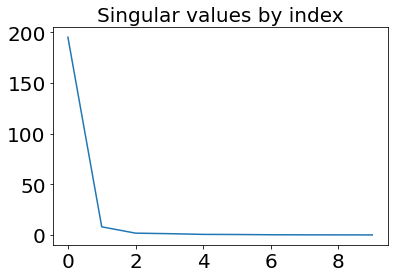

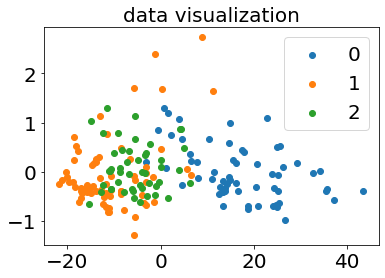

In [8]:
import matplotlib.pyplot as plt

plt.title("Singular values by index")
plt.plot(pca.singular_values_)
plt.show()

classes = [
    np.array([temp[index] for index in range(temp.shape[0]) if data[index, 0] == class_index])
    for class_index in range(1, 4)
]

for i, cls in enumerate(classes):
    plt.title("data visualization")
    plt.scatter(cls[:, 0], cls[:, 1], label=str(i))
    plt.legend()

plt.show()

Normalize a specific class

Normalization [17.07845719  0.87110537], Translation[ 7.96463043 -0.40009183]
[17.07845719  0.87110537]


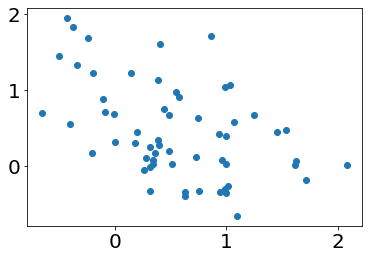

In [9]:
BOUNDARY_PERCENT = 20

current_class = classes[0]
x_min = np.percentile(current_class[:, 0], BOUNDARY_PERCENT)
x_max = np.percentile(current_class[:, 0], 100 - BOUNDARY_PERCENT)
x_len = x_max - x_min

y_min = np.percentile(current_class[:, 1], BOUNDARY_PERCENT)
y_max = np.percentile(current_class[:, 1], 100 - BOUNDARY_PERCENT)
y_len = y_max - y_min

normalization = np.array([x_len, y_len])
translation = np.array([x_min, y_min])
print(f"Normalization {normalization}, Translation{translation}")
current_class[:,:2] = (current_class[:,:2] - translation) / normalization
print(normalization)

plt.scatter(current_class[:,0], current_class[:, 1])
plt.show()

Now we start the multiscale approximation

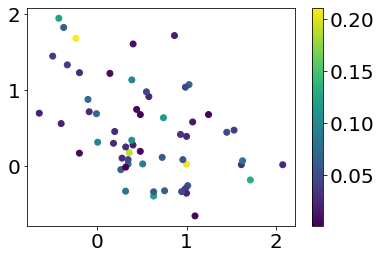

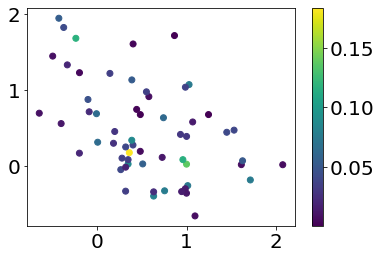

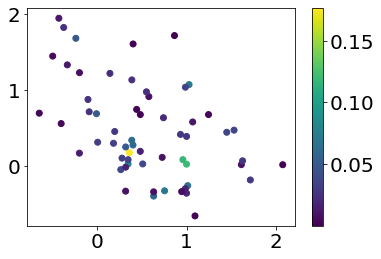

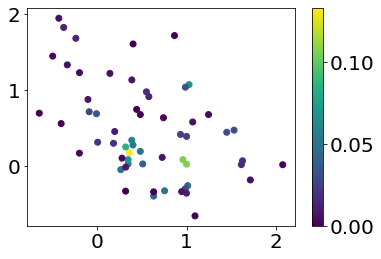

In [10]:
from Config.Options import options
import Experiment
from Config.Config import config

TARGET_COMPONENT = 2

def get_wine(x, y):
    p = np.array([x, y])
    index = np.where(np.all(current_class[:, :2]==p,axis=1))[0][0]
    return current_class[index, TARGET_COMPONENT]


base_config = {
    "MANIFOLD": options.get_option("manifold", "numbers")(),
    "NUMBER_OF_SCALES": 4,
    "SCALING_FACTOR": 0.8,
    "ORIGINAL_FUNCTION": get_wine,
    "SEQUENCE": current_class[:, :2],
    "EXECUTION_NAME": f"multiscale_wine",
    "SCALED_INTERPOLATION_METHOD": "quasi",
    "DATA_SITES_GENERATION": "thinning",
    "DATA_SITES_STORAGE": "sparse-kd-tree",
    "BASE_RESOLUTION": 3,
}

config.set_base_config(base_config)
config.renew()

for fill_distance, interpolant in Experiment.multiscale_approximation():
    approximation = [interpolant(p[0], p[1]) for p in current_class[:, :2]]
    error = [np.abs(value - current_class[i, TARGET_COMPONENT])
             for i, value in enumerate(approximation)]
    plt.scatter(current_class[:,0], current_class[:, 1], c=error)
    plt.colorbar()
    plt.show()